# Final

In [1]:
import re
import cv2
import tarfile
import warnings
import numpy as np
import pandas as pd
import xarray as xr
from PIL import Image
from io import BytesIO
from pathlib import Path
import contextlib, os, sys
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from datetime import datetime, time
from matplotlib.patches import Circle
from matplotlib.colors import rgb_to_hsv
from scipy.spatial import Delaunay, QhullError
from metpy.interpolate import natural_neighbor_to_grid  # pip install metpy or conda/mamba install -c conda-forge metpy -y
from scipy.interpolate import LinearNDInterpolator, griddata

plt.style.use("~/geoscience/albedo_downscaling/MNRAS.mplstyle")
%matplotlib inline

In [2]:
function_path = os.path.expanduser("~/geoscience/albedo_downscaling/sentinel_2/s2_functions")
sys.path.append(function_path)
# import all the helper functions.
from tsi_functions import *
# from s2_20m_download import *  
from s2_20m_download_final import *  

# ----------------------------
# Planetary Computer STAC
# ----------------------------
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Search Sentinel-2 L2A
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    # query={"eo:cloud_cover": {"lt": 60}}, # up to 60% cloud cover
)

# New:
items = list(search.items())
print(f"Returned {len(items)} items")

if not items:
    raise SystemExit("No items found for query.")

for item in items:
    date = item.datetime.date().isoformat()
    # print(f"Processing {item.id} ({date})")

# Now match TSI times to sentinel-2 items:
cdf_dir = "/bsuhome/tnde/scratch/felix/tsi_sky_cover"
tsi_times, s2_matched, tsi_files = match_tsi_to_s2(cdf_dir, items, thin_threshold=100, opaque_threshold=100)
print(len(tsi_times), len(s2_matched), len(tsi_files))

# Verify lengths align and preview
print(f"Matched pairs: {len(tsi_times)}")
for t_tsi, s2, tsi_file in list(zip(tsi_times, s2_matched, tsi_files))[:5]:
    print(f"TSI: {tsi_file} @ {t_tsi.isoformat()}  <->  S2: {s2.id} @ {s2.datetime.isoformat()}")


Returned 96 items
96 96 96
Matched pairs: 96
TSI: guctsiskycoverM1.b1.20210903.000000.custom.cdf @ 2021-09-03T17:49:00+00:00  <->  S2: S2B_MSIL2A_20210903T174909_R141_T13SCD_20210904T042732 @ 2021-09-03T17:49:09.024000+00:00
TSI: guctsiskycoverM1.b1.20210908.000000.custom.cdf @ 2021-09-08T17:49:00+00:00  <->  S2: S2A_MSIL2A_20210908T174911_R141_T13SCD_20210909T104611 @ 2021-09-08T17:49:11.024000+00:00
TSI: guctsiskycoverM1.b1.20210913.000000.custom.cdf @ 2021-09-13T17:49:00+00:00  <->  S2: S2B_MSIL2A_20210913T174909_R141_T13SCD_20210914T085302 @ 2021-09-13T17:49:09.024000+00:00
TSI: guctsiskycoverM1.b1.20210918.000000.custom.cdf @ 2021-09-18T17:50:00+00:00  <->  S2: S2A_MSIL2A_20210918T175011_R141_T13SCD_20210919T051017 @ 2021-09-18T17:50:11.024000+00:00
TSI: guctsiskycoverM1.b1.20210923.000000.custom.cdf @ 2021-09-23T17:50:00+00:00  <->  S2: S2B_MSIL2A_20210923T174949_R141_T13SCD_20210924T125157 @ 2021-09-23T17:49:49.024000+00:00


In [3]:
dl_cbh_path = "/bsuhome/tnde/scratch/felix/Sentinel-2/cloud_base_height/gucdlprofwstats4newsM1.c1/gucdlprofwstats4newsM1.c1.20211018.000000.nc"  # or .cdf if it's NetCDF-style
ds = xr.open_dataset(dl_cbh_path)        
# print(ds)                         # show variables


Time-series candidates: ['snr', 'snr_25', 'snr_75', 'w', 'w_25', 'w_75', 'noise', 'w_variance', 'w_skewness', 'w_kurtosis', 'dl_cbh', 'dl_cbh_25', 'dl_cbh_75', 'dl_cloud_frequency', 'cbw', 'cbw_25', 'cbw_75', 'cbw_up_fraction', 'ceil_cbh', 'ceil_cbh_25', 'ceil_cbh_75', 'ceil_cloud_frequency', 'ecor_temp', 'ecor_h2o', 'ecor_tke', 'ecor_ustar', 'ecor_w_var', 'ecor_w_skew', 'ecor_w_kurt', 'ecor_wt', 'ecor_wq', 'met_spr_mean', 'met_spr_min', 'met_spr_max']


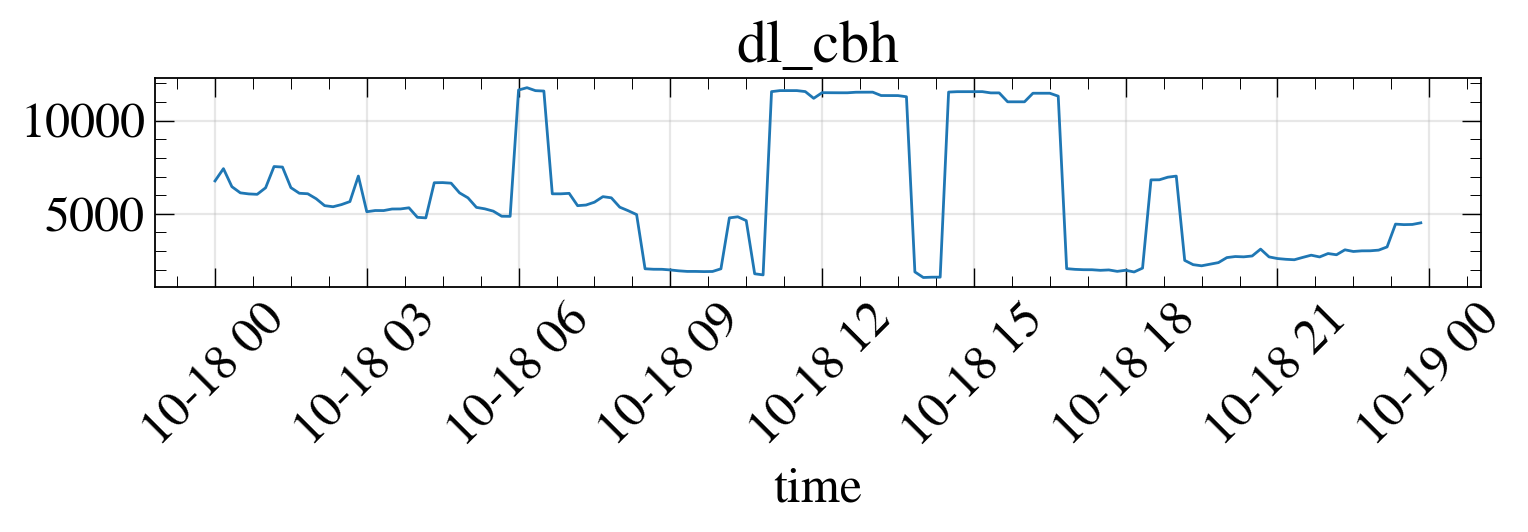

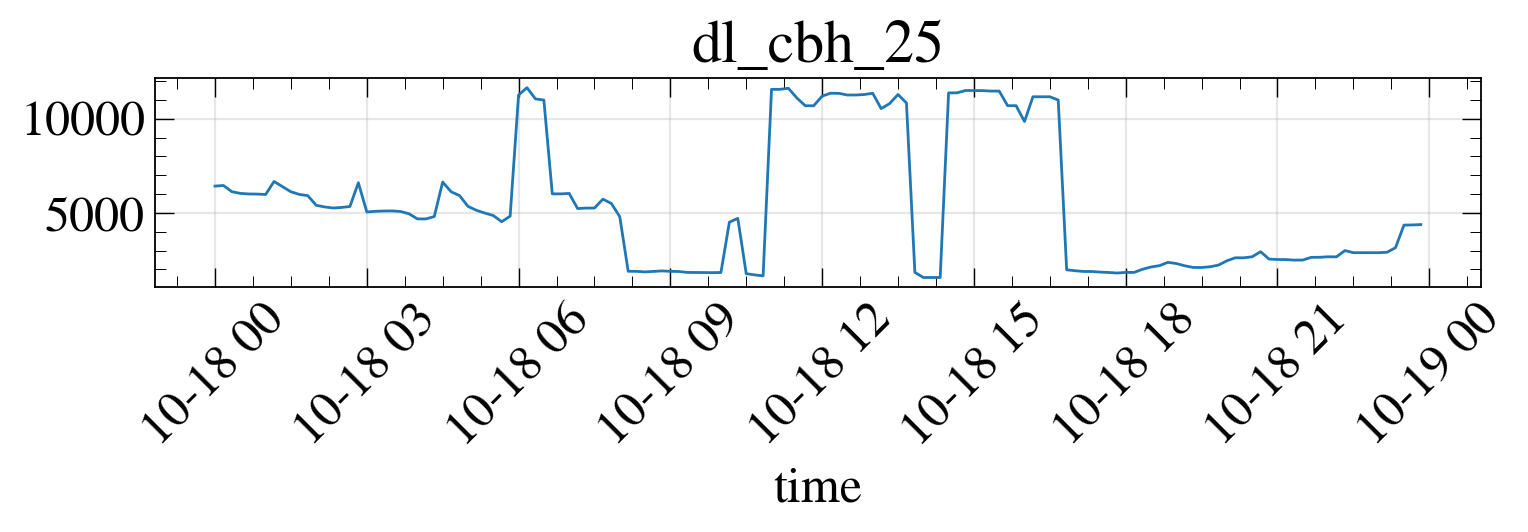

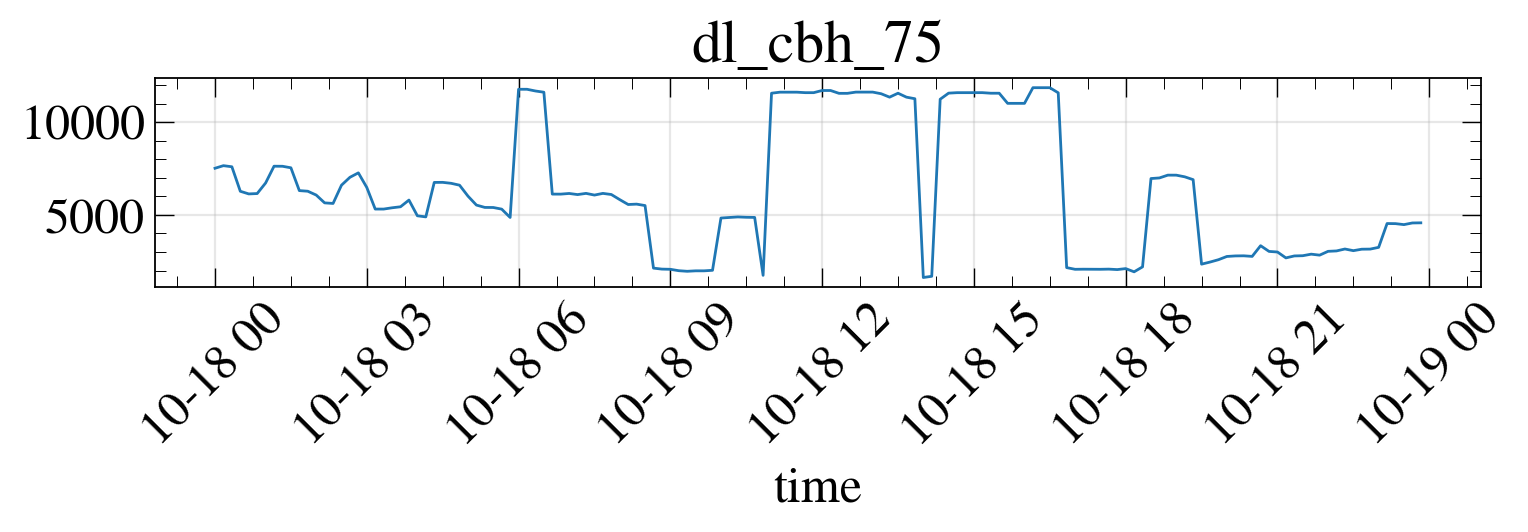

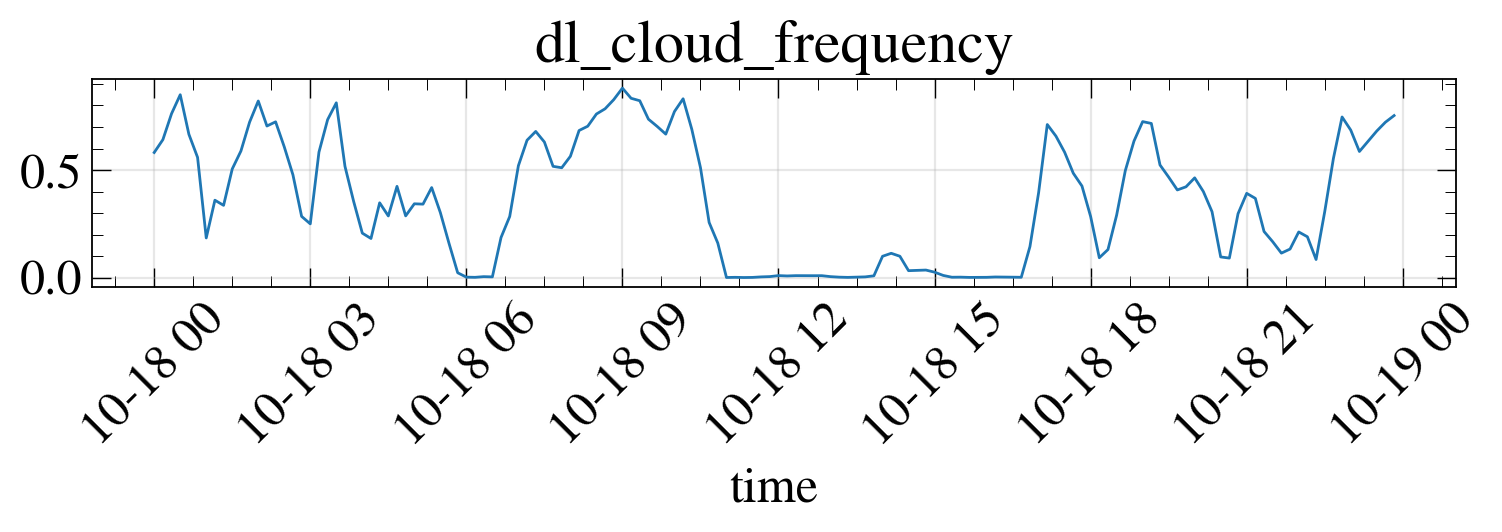

In [4]:
def is_time_series(da):
    return (np.issubdtype(da.dtype, np.number)
            and any(d in da.dims for d in ("time","Time","t")))

ts_vars = [v for v in ds.data_vars if is_time_series(ds[v])]
print("Time-series candidates:", ts_vars)

for v in ts_vars[10:14]:  # plot a few
    da = ds[v]
    t  = da["time"] if "time" in da.dims else np.arange(da.shape[0])
    plt.figure(figsize=(8,3))
    plt.plot(t, da.values, linewidth=1)
    plt.title(v)
    plt.xlabel("time")
    plt.xticks(rotation = 45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


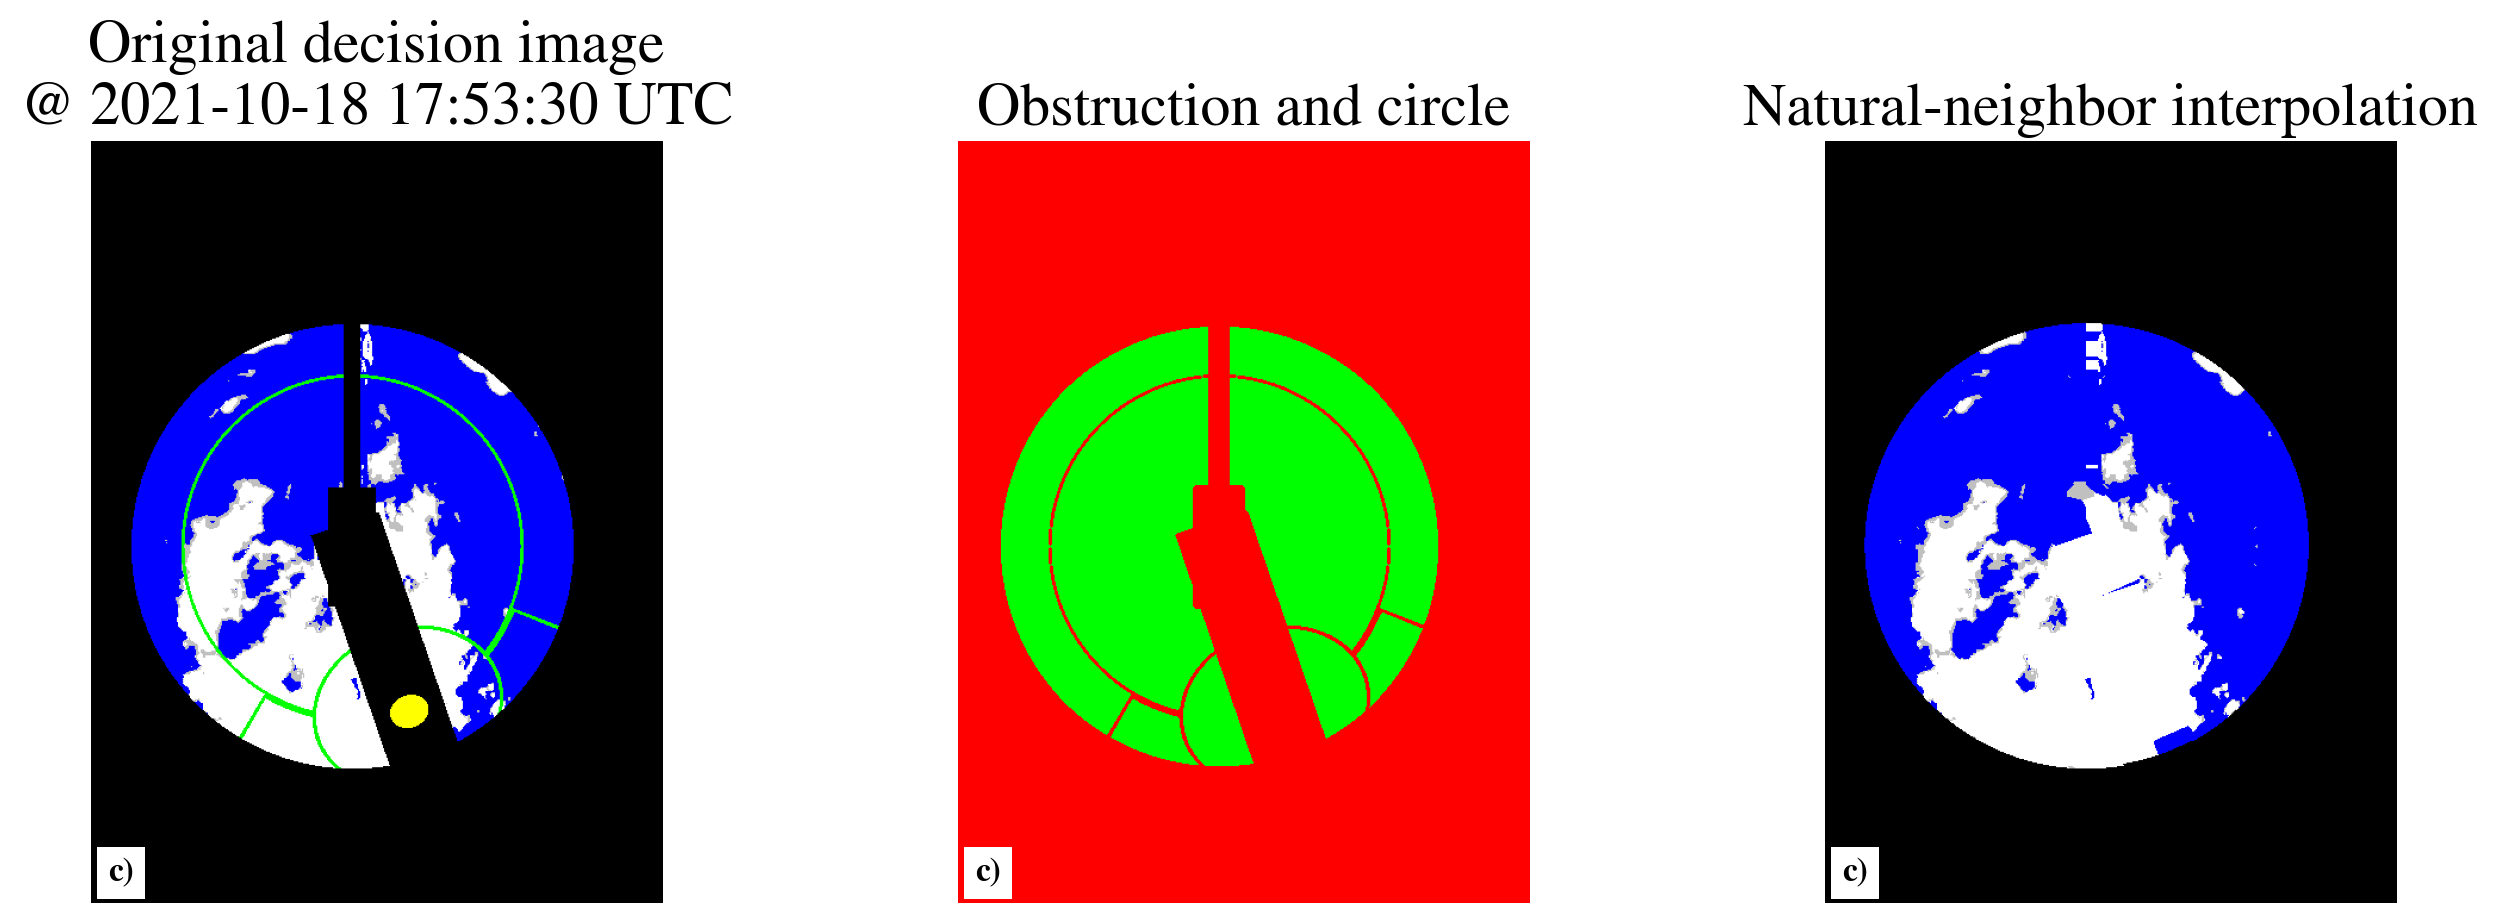

Interpolated image-space CF shape: (1,)
Planar CF shape: (1,)
Pick date shape: (1,)
Done!!!


In [5]:
# --- Select the frame at a target UTC time from a .tar of mask images ---
FINAL_TS = re.compile(r"(\d{14})\.(jpg|png)$", re.IGNORECASE)

def _list_timestamped_members(tar_path: str | Path):
    out = []
    with tarfile.open(tar_path, "r") as tf:
        for ti in tf.getmembers():
            if not ti.isfile():
                continue
            name = ti.name.lower()
            if not (name.endswith(".jpg") or name.endswith(".png")):
                continue
            m = FINAL_TS.search(ti.name)
            if m:
                ts = datetime.strptime(m.group(1), "%Y%m%d%H%M%S")
                out.append((ts, ti))
    return out

# --- Color scheme/code ---
TSI_COLORS = {
    0: (0, 0, 0),         # obstruction
    1: (0, 0, 255),       # clear sky (blue)
    2: (192, 192, 192),   # opaque cloud (white)
    3: (255, 255, 255),   # thin cloud (light gray)
}

# --- Field of View (FOV) Angle ---
FULL_FIELD_OF_VIEW = 130.0
HALF_FIELD_OF_VIEW = FULL_FIELD_OF_VIEW/2


def labels_to_rgb(label_img, color_map=TSI_COLORS):
    """Convert integer-labeled image to RGB for consistent display."""
    h, w = label_img.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for k, color in color_map.items():
        rgb[label_img == k] = color
    return rgb

def load_mask_image_at_time(tar_path: str | Path, target_time_str="17:49:00"):
    """Return RGB image and its timestamp from a daily TSI mask tar."""
    index = _list_timestamped_members(tar_path)
    if not index:
        raise RuntimeError("No timestamped JPG/PNG frames found in tar.")

    # Use the date from the archive (first entry) + requested HH:MM:SS
    archive_date = index[0][0].date()
    h, m, s = map(int, target_time_str.split(":"))
    target_ts = datetime.combine(archive_date, time(h, m, s))

    # pick nearest
    ts_series = pd.Series([ts for ts, _ in index])
    i_closest = (ts_series - target_ts).abs().argmin()
    chosen_ts, chosen_ti = index[i_closest]

    with tarfile.open(tar_path, "r") as tf:
        with tf.extractfile(chosen_ti) as f:
            img = Image.open(BytesIO(f.read())).convert("RGB")

    return np.asarray(img), chosen_ts

# --- Convert the RGB decision image to integer labels ---
def decision_rgb_to_labels(img_rgb: np.ndarray):
    """
    Map the TSI decision image (like Fig. 1c: black=non-sky, blue=clear, gray=thin, white=opaque)
    to integer labels: 0=non-sky/obstruction, 1=clear, 2=thin, 3=opaque.
    Adjust thresholds if palette differs.
    """
    r, g, b = img_rgb[..., 0], img_rgb[..., 1], img_rgb[..., 2]

    # heuristic thresholds for canonical TSI palette
    non_sky = (r < 30) & (g < 30) & (b < 30)                      # black
    clear   = (b > 150) & (r < 80) & (g < 120)                    # blue
    opaque  = (r > 220) & (g > 220) & (b > 220)                   # white
    thin    = (~non_sky) & (~clear) & (~opaque)                   # remaining as gray

    labels = np.zeros(r.shape, dtype=np.uint8)
    labels[clear] = 1
    labels[thin] = 2
    labels[opaque] = 3
    return labels

# --- Build/expand the obstruction mask (Appendix A: enlarge and dilate) ---
def build_obstruction_mask(labels: np.ndarray, dilation_px: int = 2):
    """
    Start from label==0 (non-sky: shadowband/camera arm/edge/green lines etc.),
    then expand slightly via binary dilation (Appendix A recommends widening and dilation).
    """
    base = (labels == 0)  # non-sky
    # small dilation to ensure no edge artifacts (Appendix A's expansion step)
    selem = ndi.generate_binary_structure(2, 1)
    expanded = ndi.binary_dilation(base, structure=selem, iterations=dilation_px)
    return expanded

# --- restrict interpolation strictly to the sky circular dome ---
def detect_circle_from_green(img_rgb,
                             h_range=(0.20, 0.45),           # hue range for green in [0,1] (approx. 72 degrees – 162 degrees)
                             s_min=0.20, v_min=0.20,
                             extra_green=True,               # require G > R and G > B
                             morph_open=1, morph_close=2,
                             min_points=50,                  # need at least this many green pixels
                             margin_px=4,                    # NEW: outward pixel margin
                             scale=1.00):                    # optional multiplicative grow. Shrink slightly if the ring sits inside the true edge
    """
    Detect the OUTER sky-dome circle by thresholding green guide rings, fitting a
    circle to each connected component, and choosing the component with the largest radius.

    Parameters
    ----------
    img_rgb : (H,W,3) uint8/float array
        TSI decision image in RGB.
    h_range : tuple(float,float)
        Hue range (HSV, 0–1) to keep as 'green'.
    s_min, v_min : float
        Minimum saturation and value (brightness) for green pixels.
    extra_green : bool
        If True, also require G > R and G > B (helps reject gray/white/blue).
    morph_open, morph_close : int
        Morphological opening/closing iterations to clean the ring mask.
    min_points : int
        Minimum number of ring pixels required to attempt a fit.
    shrink : float
        Multiply the fit radius by this factor when creating the circular mask.

    Returns
    -------
    circle_mask : (H,W) bool
        True inside the detected dome circle (after applying margin/scale).
    (cy, cx, r) : tuple of floats
        Fitted center (row, col) and radius BEFORE margin/scale are applied.

    Notes:
    ------
    - Uses an algebraic least-squares fit to x^2 + y^2 + A x + B y + C = 0.
      Center = (-A/2, -B/2), radius = sqrt(center^2 - C).
    - If fitting fails or too few pixels found, falls back to centered circle.
    """
    img = img_rgb.astype(np.float32) / 255.0
    H, W = img.shape[:2]

    # RGB -> HSV in [0,1] and green threshold
    hsv = rgb_to_hsv(img)
    h, s, v = hsv[..., 0], hsv[..., 1], hsv[..., 2]
    green = (h >= h_range[0]) & (h <= h_range[1]) & (s >= s_min) & (v >= v_min)
    if extra_green:
        green &= (img[...,1] > img[...,0]) & (img[...,1] > img[...,2])

    # Morphology to consolidate the ring
    if morph_open:  green = ndi.binary_opening(green, iterations=morph_open)
    if morph_close: green = ndi.binary_closing(green, iterations=morph_close)

    # Label connected components of the green mask
    lab, nlab = ndi.label(green)
    if nlab == 0:
        # Fallback: centered circle
        cy0, cx0 = (H - 1) / 2.0, (W - 1) / 2.0
        r0 = min(H, W) / 2.0
        Y, X = np.mgrid[0:H, 0:W]
        mask = (Y - cy0)**2 + (X - cx0)**2 <= (scale * r0 + margin_px)**2
        return mask, (cy0, cx0, r0)

    # Fit a circle to each component; keep the one with largest radius
    best = None
    for lbl in range(1, nlab + 1):
        yy, xx = np.nonzero(lab == lbl)
        if yy.size < min_points:
            continue
        # Algebraic least-squares circle fit (Kasa): x^2 + y^2 + A x + B y + C = 0
        x = xx.astype(np.float64)
        y = yy.astype(np.float64)
        A = np.column_stack([x, y, np.ones_like(x)]) # [x y 1]
        # Solve A*[A,B,C]^T = b
        b = -(x**2 + y**2) # RHS
        try:
            coef, *_ = np.linalg.lstsq(A, b, rcond=None)
            Acoef, Bcoef, Ccoef = coef
            cx = -Acoef / 2.0
            cy = -Bcoef / 2.0
            r = np.sqrt(max(cx*cx + cy*cy - Ccoef, 1.0))
            if (best is None) or (r > best[2]):
                best = (cy, cx, r)
        except Exception:
            continue

    # If all components were too small, fallback to global fit of all green pixels
    if best is None:
        yy, xx = np.nonzero(green)
        x = xx.astype(np.float64); y = yy.astype(np.float64)
        A = np.column_stack([x, y, np.ones_like(x)]); b = -(x**2 + y**2) 
        coef, *_ = np.linalg.lstsq(A, b, rcond=None)
        Acoef, Bcoef, Ccoef = coef
        cx = -Acoef / 2.0; cy = -Bcoef / 2.0
        r = np.sqrt(max(cx*cx + cy*cy - Ccoef, 1.0))
        best = (cy, cx, r)

    cy, cx, r = best
    r_use = (r * scale) + margin_px        # grow a bit to include full sky
    # Build circular mask
    Y, X = np.mgrid[0:H, 0:W]
    circle_mask = (Y - cy)**2 + (X - cx)**2 <= r_use**2
    return circle_mask, (cy, cx, r)

 # --- OpenCV fallback ---
def detect_circle_from_green_hough(img_rgb, dp=1.2, min_dist=50, param1=100, param2=60, min_radius=100, max_radius=0):
    import cv2
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp, minDist=min_dist,
                               param1=param1, param2=param2,
                               minRadius=min_radius, maxRadius=max_radius)
    H, W = gray.shape
    if circles is None:
        cy, cx = (H-1)/2.0, (W-1)/2.0
        r = min(H, W)/2.0
    else:
        c = circles[0][0]  # (x, y, r)
        cx, cy, r = float(c[0]), float(c[1]), float(c[2])
    Y, X = np.mgrid[0:H, 0:W]
    circle_mask = (Y - cy)**2 + (X - cx)**2 <= r**2
    return circle_mask, (cy, cx, r)

# --- Natural-neighbor interpolate ONLY inside obstruction pixels ---
def _unique_points(xs, ys, values=None):
    """Deduplicate (xs, ys). Return unique xs, ys, and optional values averaged per unique point."""
    pts = np.column_stack([xs, ys])
    uniq, inv = np.unique(pts, axis=0, return_inverse=True)
    xs_u, ys_u = uniq[:, 0], uniq[:, 1]
    if values is None:
        return xs_u, ys_u, None
    # average values that mapped to the same unique point
    acc = np.zeros(len(xs_u), dtype=float)
    cnt = np.zeros(len(xs_u), dtype=int)
    np.add.at(acc, inv, values)
    np.add.at(cnt, inv, 1)
    return xs_u, ys_u, acc / np.maximum(cnt, 1)

def _idw_at_targets(xs, ys, z, tx, ty, power=2.0, eps=1e-12):
    """Inverse Distance Weighting ONLY at target points (tx, ty)."""
    # vectorized over targets; compute in chunks to limit memory if needed
    out = np.empty(tx.size, dtype=float)
    CHUNK = max(20000, tx.size)  # adjust if very large images
    for i in range(0, tx.size, CHUNK):
        j = min(i + CHUNK, tx.size)
        dx = xs[None, :] - tx[i:j, None]
        dy = ys[None, :] - ty[i:j, None]
        d2 = dx*dx + dy*dy
        # if a target matches a sample exactly, take that value
        exact = (d2 < eps)
        if np.any(exact):
            # pick the first exact match per target
            idx_exact = np.argmax(exact, axis=1)
            mask_exact = np.any(exact, axis=1)
            out[i:j][mask_exact] = z[idx_exact[mask_exact]]
        # IDW for the rest
        mask_rest = ~np.any(exact, axis=1)
        if np.any(mask_rest):
            w = 1.0 / np.maximum(d2[mask_rest]**(power/2.0), eps)
            wz = (w * z[None, :]).sum(axis=1)
            ws = w.sum(axis=1)
            out[i:j][mask_rest] = wz / np.maximum(ws, eps)
    return out

# --- Detect overlays (green rings + yellow sun/camera flash) ---
def overlay_mask_from_colors(img_rgb,
                             green_h=(0.20, 0.45), s_min=0.25, v_min=0.20,
                             yellow_h=(0.10, 0.18), y_s_min=0.35, y_v_min=0.35,
                             morph_open=1, morph_close=1):
    """
    Return a boolean mask of non-sky overlays in the decision image:
    - green guide rings / lines
    - yellow sun marker
    """
    img = img_rgb.astype(np.float32) / 255.0
    hsv = rgb_to_hsv(img)
    h, s, v = hsv[...,0], hsv[...,1], hsv[...,2]

    # green overlays
    green = (h >= green_h[0]) & (h <= green_h[1]) & (s >= s_min) & (v >= v_min)
    green &= (img[...,1] > img[...,0]) & (img[...,1] > img[...,2])  # G > R and G > B

    # yellow sun marker
    yellow = (h >= yellow_h[0]) & (h <= yellow_h[1]) & (s >= y_s_min) & (v >= y_v_min)
    yellow &= (img[...,0] > 0.6) & (img[...,1] > 0.6)               # R,G high

    mask = green | yellow

    # Optional light cleanup
    if morph_open:
        mask = ndi.binary_opening(mask, iterations=morph_open)
    if morph_close:
        mask = ndi.binary_closing(mask, iterations=morph_close)
    return mask

def natural_neighbor_inpaint_fast(labels: np.ndarray,
                                  obstruction: np.ndarray,
                                  target_mask: np.ndarray,
                                  roi_margin: int = 8,
                                  band_px: int = 12,
                                  max_samples: int = 40_000,
                                  fallback_idw: bool = True):
    """
    Faster, robust inpainting limited to ROI using griddata (linear->nearest)
    with optional tiny IDW for any remaining NaNs. No LinearNDInterpolator used.

    Parameters
    ----------
    labels : (H,W) int
        Class map (0=non-sky, 1=clear, 2=thin, 3=opaque).
    obstruction : (H,W) bool
        Pixels to inpaint (camera arm / shadowband etc.).
    target_mask : (H,W) bool
        Region where inpainting is allowed (e.g., detected dome circle).
    roi_margin : int
        Expand the ROI bbox by this many pixels.
    band_px : int
        Valid-sample search band (dilation) around ROI.
    max_samples : int
        Cap number of scattered samples (random subsample if exceeded).
    fallback_idw : bool
        If True, do a tiny IDW only at still-missing fill pixels.

    Returns
    -------
    out : (H,W) like labels
        Labels with only obstruction∩target_mask filled.
    """
    H, W = labels.shape
    fill_mask = obstruction & target_mask
    if not np.any(fill_mask):
        return labels

    # --- ROI bbox (tight) ---
    fy, fx = np.nonzero(fill_mask)
    y0 = max(fy.min() - roi_margin, 0)
    y1 = min(fy.max() + roi_margin + 1, H)
    x0 = max(fx.min() - roi_margin, 0)
    x1 = min(fx.max() + roi_margin + 1, W)

    lab_roi  = labels[y0:y1, x0:x1]
    fill_roi = fill_mask[y0:y1, x0:x1]
    tgt_roi  = target_mask[y0:y1, x0:x1]
    obs_roi  = obstruction[y0:y1, x0:x1]

    # Valid samples near ROI
    roi_band = ndi.binary_dilation(fill_roi, iterations=band_px) & tgt_roi
    sample_mask = roi_band & (~obs_roi)
    if sample_mask.sum() < 3:
        return labels  # not enough samples

    sy, sx = np.nonzero(sample_mask)
    if sy.size > max_samples:
        idx = np.random.choice(sy.size, size=max_samples, replace=False)
        sy, sx = sy[idx], sx[idx]

    # Integer sample indices into full image (for reading labels)
    gy = (y0 + sy).astype(np.int64)
    gx = (x0 + sx).astype(np.int64)

    # Float coords for interpolation
    xs = gx.astype(np.float64)
    ys = gy.astype(np.float64)

    # Query grid (ROI only)
    YY, XX = np.mgrid[y0:y1, x0:x1]
    pts    = np.c_[xs, ys]                       # (Ns, 2)
    query  = (XX, YY)                            # griddata accepts tuple of grids

    out_roi = lab_roi.copy()
    cls_ids = [1, 2, 3]
    fields = []

    for cid in cls_ids:
        z = (labels[gy, gx] == cid).astype(np.float64)  # class indicator at samples

        # Linear interpolation on ROI grid
        zi = griddata(pts, z, query, method="linear")

        # Nearest fallback for any NaNs from linear
        if not np.all(np.isfinite(zi)):
            zi_near = griddata(pts, z, query, method="nearest")
            bad = ~np.isfinite(zi)
            zi[bad] = zi_near[bad]

        # tiny IDW at just the fill pixels still NaN (rare)
        if fallback_idw and np.any(~np.isfinite(zi[fill_roi])):
            fy2, fx2 = np.nonzero(~np.isfinite(zi) & fill_roi)
            if fy2.size:
                tx = (x0 + fx2).astype(np.float64)
                ty = (y0 + fy2).astype(np.float64)
                # IDW weights
                dx = xs[None, :] - tx[:, None]
                dy = ys[None, :] - ty[:, None]
                d2 = dx*dx + dy*dy
                w = 1.0 / np.maximum(d2, 1e-8)
                zi_fill = (w @ z) / np.sum(w, axis=1)
                zi[fy2, fx2] = zi_fill

        fields.append(zi.astype(np.float32))

    # Choose most likely class via argmax
    prob = np.stack(fields, axis=0)             # [3, h, w]
    cls_idx = np.argmax(prob, axis=0)           # 0..2 -> classes
    filled_roi = np.take(cls_ids, cls_idx)

    # Paste back only where needed
    out_roi[fill_roi] = filled_roi[fill_roi]
    out = labels.copy()
    out[y0:y1, x0:x1] = out_roi
    return out

# --- One convenience wrapper ---
def interpolate_tsi_mask_at_time(tar_path: str | Path, target_time_str="17:49:00",
                                 dilation_px: int = 2, plot=True):
    """
    Interpolate (inpaint) a TSI cloud-mask decision image at a specific UTC time using
    natural-neighbor interpolation over obstructed (non-sky) regions, and optionally
    visualize the result.

    This routine performs a single-frame workflow:
      1) Loads the TSI decision image closest to the requested `target_time_str`
         from a daily tar archive at `tar_path`.
      2) Converts the RGB decision image into class labels (e.g., 0=non-sky,
         1=clear, 2=thin, 3=opaque).
      3) Builds an obstruction mask from the non-sky class and expands it by
         `dilation_px` pixels to ensure full coverage of the shadowband/camera arm.
      4) Applies natural-neighbor interpolation to fill ONLY the obstructed pixels,
         leaving valid sky pixels unchanged.
      5) Optionally plots: (a) original decision image, (b) obstruction mask,
         (c) interpolated class map.

    Parameters
    ----------
    tar_path : str | pathlib.Path
        Path to the daily TSI image tarball that contains timestamped decision
        frames (e.g., JPG/PNG files whose names end with YYYYMMDDHHMMSS).
    target_time_str : str, optional
        Target UTC time within the archive date, formatted as "HH:MM:SS".
        The frame whose timestamp is nearest to this time will be used.
        Default is "17:49:00".
    dilation_px : int, optional
        Number of binary-dilation iterations (in pixels) used to expand the
        obstruction mask derived from the non-sky class. Larger values expand
        the region to be inpainted. Default is 2.
    plot : bool, optional
        If True, display a 1×3 figure showing the original decision image,
        the expanded obstruction mask, and the final inpainted (interpolated)
        class labels. Default is True.

    Returns
    -------
    labels_filled : numpy.ndarray
        2-D integer array of class labels after inpainting. Valid sky pixels
        retain their original class; only obstructed pixels are filled via
        interpolation.
    chosen_ts : pandas.Timestamp | datetime.datetime
        Timestamp (UTC) of the selected frame used for interpolation, i.e.,
        the frame closest to `target_time_str`.

    Notes
    -----
    - This function relies on the following helpers (expected to be defined/imported):
        -- `load_mask_image_at_time(tar_path, target_time_str)` -> (RGB array, chosen timestamp)
        -- `decision_rgb_to_labels(img_rgb)` -> 2-D label array
        -- `build_obstruction_mask(labels, dilation_px)` -> boolean mask of obstructed pixels
        -- `natural_neighbor_inpaint(labels, obstruction)` -> label array with obstruction filled
    - The interpolation fills only pixels marked as obstructed; it does not alter
      already-valid sky classifications.
    - If plotting is enabled, Matplotlib must be available as `plt`.
    """
    img_rgb, chosen_ts = load_mask_image_at_time(tar_path, target_time_str)
    labels = decision_rgb_to_labels(img_rgb)
    # obstruction from non-sky class + dilation
    obstruction = build_obstruction_mask(labels, dilation_px=dilation_px)

    # Detect circle from green rings, but pick the OUTER ring + margin
    circle_mask, (cy, cx, r) = detect_circle_from_green(img_rgb, margin_px=6, scale=1.27)
    
    # NEW: include green/yellow overlays as obstruction (only where we allow edits)
    overlay_obs = overlay_mask_from_colors(img_rgb)
    obstruction = obstruction | (overlay_obs & circle_mask)   # keep edits inside the dome

    # Interpolate ONLY where obstruction intersects the (bigger) circle
    labels_filled = natural_neighbor_inpaint_fast(
        labels,
        obstruction=obstruction,
        target_mask=circle_mask,
        roi_margin=8,
        band_px=12,
        max_samples=40000,
        fallback_idw=True,
    )

    if plot:
        fig, ax = plt.subplots(1, 3, figsize=(13, 4.5), constrained_layout=True)
        ax[0].imshow(img_rgb); 
        ax[0].set_title(f"Original decision image\n@ {chosen_ts} UTC"); 
        # add panel label in bottom-left
        ax[0].text(
            0.03, 0.02, "c)",                    # x, y in axes fraction
            transform=ax[0].transAxes,
            fontsize=12,
            fontweight="bold",
            color="black",
            ha="left",
            va="bottom",
            bbox=dict(facecolor="white", edgecolor="none", alpha=1.0),
        )
        ax[0].axis("off")

        # visualize obstruction ∩ circle
        circ_vis = np.zeros((*obstruction.shape, 3), dtype=np.uint8)
        circ_vis[..., 0] = obstruction.astype(np.uint8) * 255                   # red = obstruction
        circ_vis[..., 1] = ((~obstruction) & circle_mask).astype(np.uint8) * 255  # green = valid-in-circle
        ax[1].imshow(circ_vis); 
        ax[1].set_title("Obstruction and circle"); 
        # add panel label in bottom-left
        ax[1].text(
            0.03, 0.02, "c)",                    # x, y in axes fraction
            transform=ax[1].transAxes,
            fontsize=12,
            fontweight="bold",
            color="black",
            ha="left",
            va="bottom",
            bbox=dict(facecolor="white", edgecolor="none", alpha=1.0),
        )
        ax[1].axis("off")

        rgb_filled = labels_to_rgb(labels_filled)
        ax[2].imshow(rgb_filled)
        # im2 = ax[2].imshow(labels_filled, vmin=0, vmax=3, cmap="viridis")

        ax[2].set_title("Natural-neighbor interpolation"); 
        # add panel label in bottom-left
        ax[2].text(
            0.03, 0.02, "c)",                    # x, y in axes fraction
            transform=ax[2].transAxes,
            fontsize=12,
            fontweight="bold",
            color="black",
            ha="left",
            va="bottom",
            bbox=dict(facecolor="white", edgecolor="none", alpha=1.0),
        )
        ax[2].axis("off")
        plt.show()
    return labels_filled, chosen_ts, circle_mask, cy, cx, r

# --- projection from hemispherical to planar coordinate system ---
def project_tsi_to_planar(labels, theta_p, phi_p, cbh_m,
                          sky_mask=None, fov_max_deg=HALF_FIELD_OF_VIEW,
                          grid_res_m=None, classes=(0,1,2,3), method='linear'):
    
    """
    Project a hemispherical TSI label image to a planar (ground) coordinate grid.

    Parameters
    ----------
    labels : (H,W) int
        Integer class map after inpainting (e.g., 0=non-sky/obstruction, 1=clear, 2=thin, 3=opaque).
    theta  : (H,W) float [radians]
        Per-pixel zenith angle theta_p after mirror/lens calibration.
    phi    : (H,W) float [radians]
        Per-pixel azimuth angle phi_p (e.g., 0 = +x (east), increasing counter-clockwise).
    cbh_m  : float
        Cloud base height (meters) for this timestamp (single value), e.g., from lidar/ARSCL.
    sky_mask : (H,W) bool, optional
        True for valid sky pixels inside usable FOV (e.g., the detected dome circle minus outside/black).
        If None, all pixels with finite theta are used.
    fov_max_deg : float
        Maximum zenith angle to keep (half-angle of FOV). For example, 65 degrees corresponds to a 130 degrees full FOV used in the paper. 
        Pixels with θ>fov_max are dropped. 
    grid_res_m : float or None
        Target planar grid resolution (meters). If None, it follows Appendix D:
        grid_res ≈ D/(2*nw), with D = 2*CBH*tan(θ_max), nw=image width. 
    classes : tuple of ints
        Class IDs to reconstruct on the plane.
    method : {'linear','nearest'}
        Interpolation for the per-class indicator fields on the plane (triangulation-based linear as in the paper,
        with nearest fallback where linear returns NaNs).

    Returns
    -------
    plane_labels : (Ny,Nx) int
        Class map on the planar grid.
    xg, yg : (Ny,Nx) float
        Meshgrid coordinates (meters) centered at the imager.
    extent : tuple
        (xmin, xmax, ymin, ymax) for plotting with imshow.
        
    NOTE from a quick search on Google: 
    Solar altitude (or elevation) and solar zenith angle are complementary angles, meaning their sum always equals 90 degrees. 
    The solar altitude is the angle between the sun's rays and the horizontal plane, 
    while the solar zenith angle is the angle between the sun's rays and the vertical direction. 
    Therefore, if you know one of these angles, you can easily calculate the other using the simple formula: Solar Zenith Angle = 90 - Solar Altitude (all in degrees). 
    """
    
    H, W = labels.shape
    if sky_mask is None:
        sky_mask = np.isfinite(theta_p)

    fov_max = np.deg2rad(fov_max_deg)

    # valid image pixels (inside circle/FOV)
    valid = sky_mask & np.isfinite(theta_p) & np.isfinite(phi_p) & (theta_p <= fov_max)
    if not np.any(valid):
        raise ValueError("No valid pixels inside the requested FOV.")

    # Spherical -> planar
    r = cbh_m * np.tan(theta_p[valid])
    xs = r * np.cos(phi_p[valid])
    ys = r * np.sin(phi_p[valid])

    # Planar grid bounds + resolution (disk diameter D)
    Rg = cbh_m * np.tan(fov_max)          # radius of valid disk on the plane
    D  = 2.0 * Rg
    if grid_res_m is None:
        grid_res_m = D / (2.0 * W)

    half = 0.5 * D
    xmin, xmax = -half, half
    ymin, ymax = -half, half

    nx = int(np.ceil((xmax - xmin) / grid_res_m))
    ny = int(np.ceil((ymax - ymin) / grid_res_m))
    xg = np.linspace(xmin, xmax, nx, dtype=np.float64)
    yg = np.linspace(ymin, ymax, ny, dtype=np.float64)
    Xg, Yg = np.meshgrid(xg, yg)

    # --- Disk-of-validity mask on the plane ---
    plane_disk = (Xg**2 + Yg**2) <= (Rg**2)

    # Interpolate class-indicator fields only for pixels INSIDE the disk
    pts   = np.c_[xs, ys]
    labs  = labels[valid].astype(int)
    fields = []

    for cid in classes:
        z = (labs == cid).astype(np.float64)

        # Start with NaNs everywhere and fill only inside the disk
        Zi = np.full(Xg.shape, np.nan, dtype=np.float64)

        # linear interpolation on the inside pixels
        Zi_in = griddata(pts, z, (Xg[plane_disk], Yg[plane_disk]), method=method)

        # nearest fallback for any NaNs inside the disk
        bad = ~np.isfinite(Zi_in)
        if np.any(bad):
            Zi_in2 = griddata(pts, z, (Xg[plane_disk][bad], Yg[plane_disk][bad]),
                              method='nearest')
            Zi_in[bad] = Zi_in2

        # write only inside the disk; leave outside as NaN
        Zi[plane_disk] = Zi_in
        fields.append(Zi.astype(np.float32))

    probs = np.stack(fields, axis=0)                     # [nclass, ny, nx]

    # Outside the disk, force class 0 (black) by skipping argmax there
    plane_labels = np.zeros(Xg.shape, dtype=int)

    # For the interior, choose the most likely class
    idx_interior = np.argmax(probs[:, plane_disk], axis=0)   # 0..len(classes)-1
    plane_labels[plane_disk] = np.take(np.asarray(classes), idx_interior)

    extent = (xmin, xmax, ymin, ymax)
    return plane_labels, Xg, Yg, extent

# --- per-pixel view angles ---
def make_view_angles_from_circle(H, W, cy, cx, R, theta_max_deg=HALF_FIELD_OF_VIEW, circle_mask=None):
    """
    Build per-pixel view angles (theta_p, phi_p) from a simple equidistant model:
        theta_p = theta_max * (rho / R),   phi_p = atan2(y-cy, x-cx)
    Pixels beyond the circle are masked out (set to NaN in theta_p).
    """
    Y, X = np.mgrid[0:H, 0:W]
    dy = Y - float(cy)
    dx = X - float(cx)
    rho = np.sqrt(dx*dx + dy*dy)
    theta_max = np.deg2rad(theta_max_deg)

    # equidistant mapping (clip at R)
    rho_clipped = np.minimum(rho, R)
    theta_p = theta_max * (rho_clipped / float(R))
    phi_p   = np.arctan2(dy, dx)

    if circle_mask is not None:
        theta_p = np.where(circle_mask, theta_p, np.nan)
        phi_p   = np.where(circle_mask,  phi_p,   np.nan)

    return theta_p.astype(np.float32), phi_p.astype(np.float32)

# --- Overlay FOV circle ---
def overlay_fov_from_theta(ax, img_rgb, theta_p, theta_max_deg=HALF_FIELD_OF_VIEW, color="red", lw=2):
    ax.imshow(img_rgb)
    # draw theta = HALF_FIELD_OF_VIEW degrees contour
    ax.contour(theta_p, levels=[np.deg2rad(theta_max_deg)],
               colors=[color], linewidths=lw)
    # # black out theta > HALF_FIELD_OF_VIEW degrees (outside usable FOV)
    # outside = theta_p > np.deg2rad(theta_max_deg)
    # black = np.zeros_like(img_rgb)
    # ax.imshow(black, alpha=outside.astype(float))
    ax.axis("off")

def draw_fov_circle(ax, cbh_m, fov_full_deg=FULL_FIELD_OF_VIEW, color="red", lw=2, label=False):
    theta_max = np.deg2rad(fov_full_deg/2.0)  # HALF_FIELD_OF_VIEW
    Rg = cbh_m * np.tan(theta_max)
    ax.add_patch(Circle((0.0, 0.0), Rg, fill=False, edgecolor=color, lw=lw, zorder=5))
    ax.set_aspect("equal", adjustable="box")
    if label:
        ax.text(0, Rg*1.02, f"{int(fov_full_deg)}° FOV", color=color,
                ha="center", va="bottom", fontsize=9, weight="bold")
    return Rg

def black_outside_planar(ax, extent, Rg, nx, ny):
    xmin, xmax, ymin, ymax = extent
    xv = np.linspace(xmin, xmax, nx)
    yv = np.linspace(ymin, ymax, ny)
    X, Y = np.meshgrid(xv, yv)
    outside = (X**2 + Y**2) > (Rg**2)
    ax.imshow(np.zeros((ny, nx, 3), dtype=np.uint8), origin="lower",
              extent=extent, alpha=outside.astype(float))
    ax.axis("off") 

def project_entire_circle_to_planar(labels,                                # (H,W) int; the interpolated classes
                                    circle_mask,                           # (H,W) bool; True inside dome circle
                                    cy, cx, R_pix,                         # circle center (row, col) and radius in pixels
                                    cbh_m,                                 # cloud-base height (meters)
                                    theta_edge_deg=HALF_FIELD_OF_VIEW,     # zenith angle at circle edge; set per the instrument
                                    grid_res_m=None,                       # None -> choose from diameter and image width
                                    classes=(0,1,2,3),
                                    method='linear'):
    """
    Project the entire circular TSI region (defined by circle_mask) to planar (x,y) using a single CBH.

    Model: equidistant fisheye  theta_p = theta_edge * (rho / R_pix),  phi_p = atan2(y-cy, x-cx)
    Plane mapping: r = CBH * tan(theta_p),  x = r cos(phi_p),  y = r sin(phi_p)
    """
    H, W = labels.shape
    yy, xx = np.mgrid[0:H, 0:W]
    dy = yy - float(cy)
    dx = xx - float(cx)
    rho = np.sqrt(dx*dx + dy*dy)

    # *** FIX 1: derive effective R_pix from the actual circle_mask ***
    # This makes the edge angle correspond to the *true* edge of the dome in pixels.
    R_pix_eff = rho[circle_mask].max()

    # Per-pixel view angles over the entire circle/dome
    theta_edge = np.deg2rad(theta_edge_deg)
    theta_p = np.full_like(rho, np.nan, dtype=np.float32)

    in_circle = circle_mask
    # use R_pix_eff here (not the original R_pix argument)
    theta_p[in_circle] = theta_edge * (rho[in_circle] / float(R_pix_eff))
    phi_p = np.full_like(theta_p, np.nan, dtype=np.float32)
    phi_p[in_circle] = np.arctan2(dy[in_circle], dx[in_circle])

    # Keep only valid (in-circle) samples
    valid = in_circle & np.isfinite(theta_p) & np.isfinite(phi_p)

    # Spherical -> planar
    r = cbh_m * np.tan(theta_p[valid])
    xs = r * np.cos(phi_p[valid])
    ys = r * np.sin(phi_p[valid])

    # Planar disk radius for the entire circle/dome
    Rg = cbh_m * np.tan(theta_edge)        # meters
    D  = 2.0 * Rg
    if grid_res_m is None:
        grid_res_m = D / (2.0 * W)         # convenient, image-width tied

    half = 0.5 * D
    xmin, xmax = -half, half
    ymin, ymax = -half, half
    nx = int(np.ceil((xmax - xmin) / grid_res_m))
    ny = int(np.ceil((ymax - ymin) / grid_res_m))
    xg = np.linspace(xmin, xmax, nx, dtype=np.float64)
    yg = np.linspace(ymin, ymax, ny, dtype=np.float64)
    Xg, Yg = np.meshgrid(xg, yg)

    # Disk-of-validity on plane: everything inside the projected dome
    plane_disk = (Xg**2 + Yg**2) <= (Rg**2)

    # Interpolate per-class indicator fields inside the plane disk only
    pts = np.c_[xs, ys]
    labs = labels[valid].astype(int)
    fields = []
    for cid in classes:
        z = (labs == cid).astype(np.float64)

        Zi = np.full(Xg.shape, np.nan, dtype=np.float64)
        Zi_in = griddata(pts, z, (Xg[plane_disk], Yg[plane_disk]), method=method)
        # nearest fallback for holes
        bad = ~np.isfinite(Zi_in)
        if np.any(bad):
            Zi_in[bad] = griddata(pts, z,
                                  (Xg[plane_disk][bad], Yg[plane_disk][bad]),
                                  method='nearest')
        Zi[plane_disk] = Zi_in
        fields.append(Zi.astype(np.float32))

    probs = np.stack(fields, axis=0)                 # [nclass, ny, nx]

    # Outside disk -> class 0 (black)
    plane_labels = np.zeros(Xg.shape, dtype=int)
    idx_in = np.argmax(probs[:, plane_disk], axis=0)
    plane_labels[plane_disk] = np.take(np.asarray(classes), idx_in)

    extent = (xmin, xmax, ymin, ymax)
    return plane_labels, Xg, Yg, extent, Rg
    
    
# --- NEW: helper to compute cloud fraction from a label map + mask ---
def _cloud_fraction_from_labels(labels: np.ndarray,
                                valid_mask: np.ndarray,
                                cloudy_classes=(2, 3)) -> float:
    """
    Cloud fraction = (# pixels whose label is in `cloudy_classes`) / (# valid pixels in `valid_mask`).
    Returns np.nan if no valid pixels.
    """
    vm = valid_mask.astype(bool)
    if not np.any(vm):
        return np.nan
    lab = labels[vm]
    cloud = np.isin(lab, cloudy_classes)
    return float(np.count_nonzero(cloud) / lab.size)


if __name__ == "__main__":
    # Directory containing all tsi cloud mask .tar files
    tsi_cloud_mask_dir = "/bsuhome/tnde/scratch/felix/tsi_cloud_mask"
    dl_cbh_dir = "/bsuhome/tnde/scratch/felix/Sentinel-2/cloud_base_height/gucdlprofwstats4newsM1.c1"  # path to the Doppler lidar cloud base height (dl_cbh) data

    # List of all .tar files in the directory
    # tar_files = [f for f in os.listdir(dir_path) if f.endswith(".tar")] # only file names
    tar_files = [os.path.join(tsi_cloud_mask_dir, f) for f in os.listdir(tsi_cloud_mask_dir) if f.endswith(".tar")] # full path to the files
    cbh_files = [os.path.join(dl_cbh_dir, f) for f in os.listdir(dl_cbh_dir) if f.endswith(".nc")] # full path to the files

    # NEW: collectors for the two series
    cf_interp_list = []
    cf_planar_list = []
    pick_date_list = []
    
    # for i in range(len(tsi_times)):
    for i in range(9,10):
        pick_date = str(tsi_times[i].date()).replace("-","")
        pick_time = str(tsi_times[i].time())
        pick_date_list.append(tsi_times[i].date())
        # print(pick_time)
        
         # --- run for daily tar of decision images ---
        # tsi_cloud_mask_path = "/bsuhome/tnde/scratch/felix/tsi_cloud_mask/guctsicldmaskM1.a1.20220901.000000.png.tar"

        # Filter files by date
        matching_tsi_cloud_mask_files = [f for f in tar_files if pick_date in f]
        matching_cbh_files = [f for f in cbh_files if pick_date in f]
        
        if (len(matching_tsi_cloud_mask_files) == 1)&(len(matching_cbh_files) == 1):
            tsi_cloud_mask_path = matching_tsi_cloud_mask_files[0]
            dl_cbh_path = matching_cbh_files[0]
        else:
            print("Multiple files detected for same day")
            print(f"Date: {date}. \nTime: {time}. \nLength: {len(matching_tsi_cloud_mask_files)}. \nMatched tsi File list {matching_tsi_cloud_mask_files}")
            print(f"Date: {date}. \nTime: {time}. \nLength: {len(matching_cbh_files)}. \nMatched cbh File list {matching_cbh_files}")
            print("We will proceed with the first file in each list")
            tsi_cloud_mask_path = matching_tsi_cloud_mask_files[0]
            dl_cbh_path = matching_cbh_files[0]
            # continue
    
        cbh_ds = xr.open_dataset(dl_cbh_path) 
        target_cbh_time = f"{str(tsi_times[i].date())}T{str(tsi_times[i].time())}" 
        # with 10 minutes tolerance. Skip if time difference is too far (i.e. beyond tolerance level)
        sel_target_cbh_time = cbh_ds.sel(time=target_cbh_time, method="nearest", tolerance="10min") # cbh data is collected every 10 minutes.
        cbh_value = sel_target_cbh_time["dl_cbh_25"].values
        
        filled_labels, ts, circle_mask, cy, cx, r = interpolate_tsi_mask_at_time(tsi_cloud_mask_path, target_time_str=pick_time, dilation_px=2, plot=True)

        # size of image to broadcast to
        H, W = filled_labels.shape   # for example, from the inpainted label image

        # Build per-pixel view angles from the dome/circle
        theta_p, phi_p = make_view_angles_from_circle(H, W, cy, cx, R=r,  # use the detected outer-ring radius
                                                      theta_max_deg=HALF_FIELD_OF_VIEW, 
                                                      circle_mask=circle_mask)

        # Project using per-pixel angles 
        plane_labels, Xg, Yg, extent = project_tsi_to_planar(
            filled_labels, theta_p, phi_p,
            cbh_m=cbh_value,
            sky_mask=circle_mask,
            fov_max_deg=HALF_FIELD_OF_VIEW, 
            grid_res_m=None,
            method='linear'
        )

        # NEW: compute two cloud fractions and collect them

        # Ensure CBH is a scalar float
        cbh_scalar = float(np.asarray(cbh_value).squeeze())

        # (A): Interpolated image–space cloud fraction (use entire sky circle)
        #      cloudy classes = 2 (thin), 3 (opaque).
        cf_interp = _cloud_fraction_from_labels(
            labels=filled_labels,
            valid_mask=circle_mask,
            cloudy_classes=(2, 3)
        )
        cf_interp_list.append(cf_interp)

        # (B): Planar cloud fraction (inside planar FOV disk)
        #      radius on plane for HALF_FIELD_OF_VIEW (FULL_FIELD_OF_VIEW/2)
        Rg = cbh_scalar * np.tan(np.deg2rad(HALF_FIELD_OF_VIEW))
        plane_disk = (Xg**2 + Yg**2) <= (Rg**2)

        cf_planar = _cloud_fraction_from_labels(
            labels=plane_labels,
            valid_mask=plane_disk,
            cloudy_classes=(2, 3)
        )
        cf_planar_list.append(cf_planar)

        # # Plot with original color scheme
        # rgb_plane = labels_to_rgb(plane_labels)
        # fig, ax = plt.subplots(figsize=(6,6))
        # ax.imshow(rgb_plane, extent=extent)
        # # ax.set_xlabel('x (m)'); plt.ylabel('y (m)')
        # ax.set_title('TSI mask projected to planar coordinates')
        # ax.axis("off")    
        # plt.show()

        # # Plot with original color scheme
        # rgb_plane = labels_to_rgb(plane_labels)
        # fig, ax = plt.subplots(figsize=(6,6))
        # ax.imshow(rgb_plane, extent=extent) 
        # # ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)")
        # ax.set_title("Planar projection") # with FULL_FIELD_OF_VIEW")
        # ax.axis("off")   
        # plt.show()

        # Rg = draw_fov_circle(ax, cbh_m=cbh_value, fov_full_deg=FULL_FIELD_OF_VIEW, color="red", lw=2)
        
    # NEW: convert cloud fraction lists to arrays 
    cf_interp_arr = np.asarray(cf_interp_list, dtype=float)
    cf_planar_arr = np.asarray(cf_planar_list, dtype=float)
    pick_date_arr = np.asarray(pick_date_list)
    pick_date_arr2 = pd.to_datetime(pick_date_arr, errors="coerce")
    
    # cf_df = pd.DataFrame({
    # "date": pick_date_arr2, # pick_date_arr2,
    # "cf_interp": cf_interp_arr,
    # "cf_planar": cf_planar_arr,
    # })

    # # Save to CSV
    # cf_out_path = "/bsuhome/tnde/scratch/felix/Sentinel-2/s2_albedo_outputs/tsi_cloud_fractions.csv"
    # cf_df.to_csv(cf_out_path, index=False)

    # print(f"Saved {len(cf_df)} rows to {cf_out_path}")
    
    print("Interpolated image-space CF shape:", cf_interp_arr.shape)
    print("Planar CF shape:", cf_planar_arr.shape)
    print("Pick date shape:", cf_planar_arr.shape)

    print("Done!!!")

In [6]:
# len(cf_planar_arr[cf_planar_arr<=0.10])
# pick_date_arr

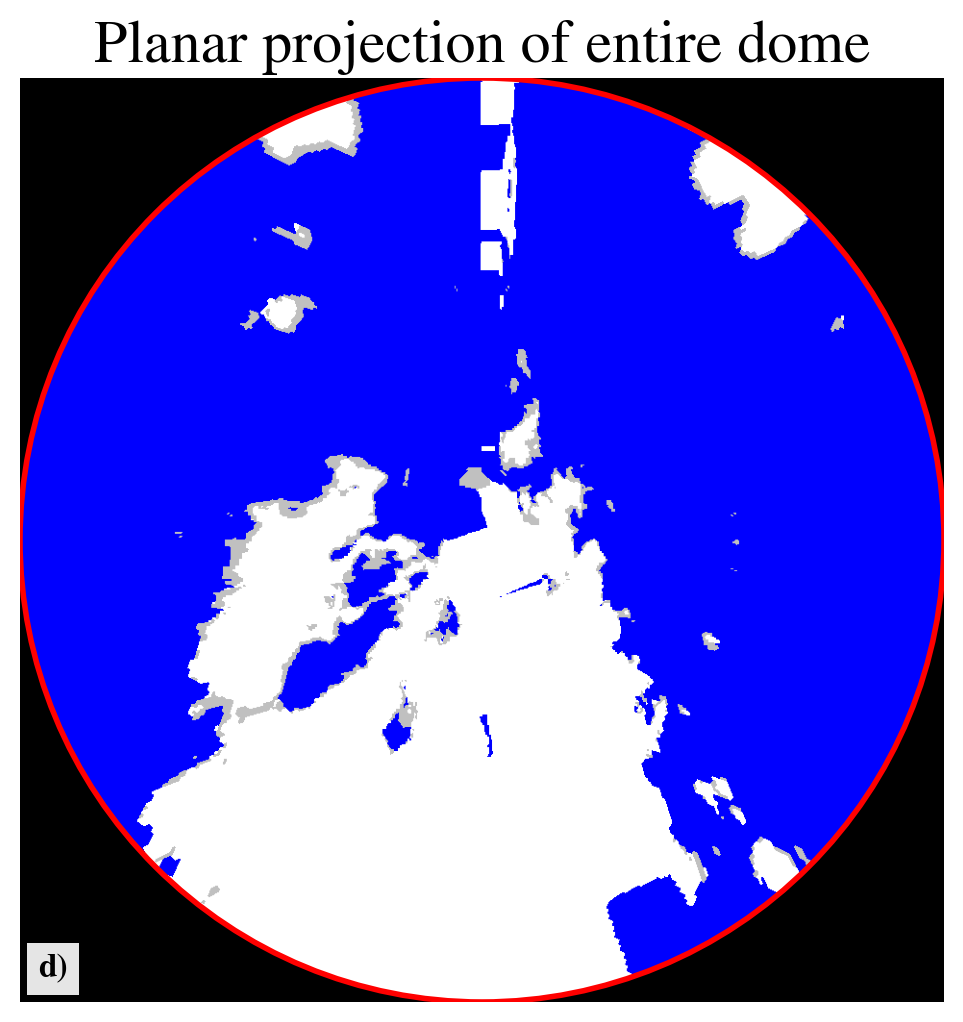

In [7]:
FULL_FIELD_OF_VIEW = 130.0
HALF_FIELD_OF_VIEW = FULL_FIELD_OF_VIEW/2
plane_labels, Xg, Yg, extent, Rg = project_entire_circle_to_planar(
    filled_labels, circle_mask, cy, cx, r,
    cbh_m=cbh_value,
    theta_edge_deg=HALF_FIELD_OF_VIEW,     # <-- pick the edge angle for the dome circle
    grid_res_m=None,
    classes=(0,1,2,3),
    method='linear'
)

# Plot with the original color scheme, black outside disk
rgb_plane = labels_to_rgb(plane_labels)

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(rgb_plane, extent=extent)
# ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)")
ax.set_title("Planar projection of entire dome")
# optional: draw the edge circle
ax.add_patch(Circle((0,0), Rg, edgecolor="red", facecolor="none", lw=2))
ax.set_aspect("equal", adjustable="box")
# add panel label in bottom-left
ax.text(
    0.02, 0.02, "d)",                    # x, y in axes fraction
    transform=ax.transAxes,
    fontsize=12,
    fontweight="bold",
    color="black",
    ha="left",
    va="bottom",
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.9),
)
ax.axis("off")
plt.show()